In [34]:
import sys
sys.path.append('/home/maria/Documents/projects/synthetic_anomaly/')

### **Patch Sampling**

#### **Imports**

In [35]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

from constants import MVTEC, GAMMA_PARAMS, OBJECT_RESIZE_BOUNDS, TEXTURE_RESIZE_BOUNDS

#### **Configurations/Constants**

In [36]:
CLASS = 'hazelnut'
IMAGE1_PATH = f'/home/maria/Documents/projects/synthetic_anomaly/MVTec_{CLASS}_normal_clone/0_ima_dest_{CLASS}.png'
IMAGE2_PATH = f'/home/maria/Documents/projects/synthetic_anomaly/MVTec_{CLASS}_normal_clone/10_ima_dest_{CLASS}.png'


if MVTEC[CLASS]['type'] == 'object':
    resize_bounds=OBJECT_RESIZE_BOUNDS
else:
    resize_bounds=TEXTURE_RESIZE_BOUNDS

#### **SandBox -- REMOVE**

In [37]:
def display_images_side_by_side(images: list, titles: list=None, config_cmap: list[None, str]=None):

    num_images = len(images)
    
    if num_images < 1 or num_images > 4:
        raise ValueError("This function supports between 1 and 4 images.")
    
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    
    if num_images == 1:
        axes = [axes]
    
    for i, image in enumerate(images):
        if config_cmap[i] is not None:
            axes[i].imshow(image, cmap=config_cmap[i])
        else:
            axes[i].imshow(image)
            
        axes[i].axis('off')  
        if titles and i < len(titles):  
            axes[i].set_title(titles[i])

    plt.show()

def plot_gamma_distribution(alpha, beta):

    samples = np.random.gamma(alpha, beta, 100000)  

    random_value = np.random.choice(samples)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(samples, bins=100, density=True, alpha=0.6, color='grey', edgecolor='black') 

    x = np.linspace(0, np.max(samples), 1000)
    pdf = (x ** (alpha - 1) * np.exp(-x / beta)) / (beta ** alpha * np.math.gamma(alpha))

    plt.plot(x, pdf, color='blue', lw=2, label='Theoretical PDF')  

    plt.axvline(random_value, color='red', linestyle='--', linewidth=2, label=f'Randomly Selected Value: {random_value:.2f}')
    plt.scatter(random_value, 0, color='red', s=200, zorder=5, edgecolor='grey', linewidth=2)

    plt.annotate(f'{random_value:.2f}', 
                 xy=(random_value, 0), 
                 xytext=(random_value + 7 * beta, 20 * beta),  
                 arrowprops=dict(facecolor='blue', shrink=0.03),
                 fontsize=12,
                 color='red')

    plt.title(f'Samples from Gamma Distribution (α={alpha}, β={beta})')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

def compute_hw_distributions(hmin, hmax, wmin, wmax, H, W, gamma_params=GAMMA_PARAMS, iterations=1000):

    h_values = []
    w_values = []


    for _ in range(iterations):
        rh, rw = np.random.gamma(shape=gamma_params['shape'], scale=gamma_params['scale'], size=2)

        h_perc = np.minimum(np.maximum(hmin, 0.06 + rh), hmax)
        w_perc = np.minimum(np.maximum(wmin, 0.06 + rw), wmax)
        
        h = (H * h_perc).round().astype(int)
        w = (W * w_perc).round().astype(int)
        
        h_values.append(h)
        w_values.append(w)
        
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(h_values, bins=30, color='grey', edgecolor='black')
    plt.title("Distribution of h")
    plt.xlabel("h values")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(w_values, bins=30, color='grey', edgecolor='black')
    plt.title("Distribution of w")
    plt.xlabel("w values")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

def plot_patch_mask(x,y, patch_size, mask, mask_patch, image, perc):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

    center_x = patch_size[1] // 2
    center_y = patch_size[0] // 2

    ax1.imshow(mask, cmap='gray')
    rect = patches.Rectangle((x, y), patch_size[1], patch_size[0], linewidth=2, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title("Original Mask with Patch Location")
    ax1.axis('off')

    ax2.imshow(image)
    rect = patches.Rectangle((x, y), patch_size[1], patch_size[0], linewidth=2, edgecolor='red', facecolor='none')
    ax2.add_patch(rect)
    ax2.set_title("Original Mask with Patch Location")
    ax2.axis('off')

    ax3.imshow(mask_patch, cmap='gray')
    ax3.set_title(f"Extracted Patch percentage={round(perc*100, 2)}")
    ax3.axis('off')

    plt.show()

def plot_rectangule_img(rect_coods, image):

    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    #plt.axis('off')

    #rect_coods = (y_range, x_range) -> this sequence
    rect = patches.Rectangle(
        (rect_coods[1][0], rect_coods[0][0]), 
        rect_coods[1][1] - rect_coods[1][0],   
        rect_coods[0][1] - rect_coods[0][0],  
        linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
    
    plt.gca().add_patch(rect)

    plt.title("Search Area for Patch (Red Rectangle)")
    plt.show()

def plot_patch_mask(x,y, patch_size1, mask, image, titles, patch_size2=None):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(image)
    rect = patches.Rectangle((x, y), patch_size1[1], patch_size1[0], linewidth=1, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title(titles[0])
    #ax2.axis('off')


    ax2.imshow(mask, cmap='gray')
    if patch_size2 is None:
        rect = patches.Rectangle((x, y), patch_size1[1], patch_size1[0], linewidth=1, edgecolor='red', facecolor='none')
    else:
        rect = patches.Rectangle((x, y), patch_size2[1], patch_size2[0], linewidth=1, edgecolor='red', facecolor='none')

    ax2.add_patch(rect)
    ax2.set_title(titles[1])
    #ax1.axis('off')
    
    plt.show()


#### **Debbuging**

The Patch Sampling begins with at least one normal image, since the patch can be extracted from the same image and pasted elsewhere. Let's see how the code works, step by step, by having as samples two images from the **MVTec AD** dataset and call them `src_image` (source image) and `dest_image` (destination image). We are using the resized **MVTec** images from 1024x1024 to 256x256.

In [38]:
def read_image(path_to_image: str, mask_image: bool, scale: bool=False):
    
    img = Image.open(path_to_image)

    if mask_image:
        img = img.converter("L") # greyscale
        binary_mask = np.array(img) > 127
        return binary_mask.astype(np.uint8)

    img = np.array(img.convert('RGB'))
    if scale:
        return img.astype('double') / 255.0

    return img


In [39]:
src_image = read_image(path_to_image=IMAGE1_PATH, mask_image=False, scale=False)
dest_image = read_image(path_to_image=IMAGE2_PATH, mask_image=False, scale=False)

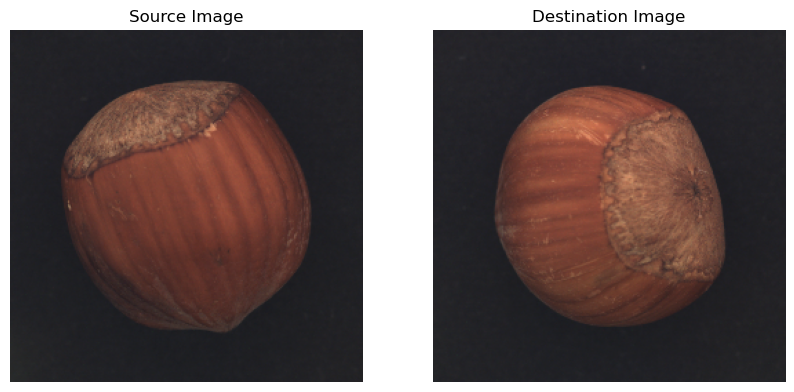

In [40]:
display_images_side_by_side(images=[src_image, dest_image], titles=['Source Image', 'Destination Image'], config_cmap = [None, 'grey', 'grey'])

For every class within the **MVTec AD** dataset the paper stipulates the maximum and minimum initial percentages the sampled patch should have in relation to the image.

These percentages is used on the the dimensions of the destination image, the image that will receive the sampled patch.

In [41]:
bounds = MVTEC[CLASS]['patch_size_bounds']

H, W, _ = np.array(dest_image.shape)
(hmin, hmax), (wmin, wmax) = bounds

min_patch_dim = (bounds[:, 0] * np.array([H,W])).round().astype(int)
max_patch_dim = (bounds[:, 1] * np.array([H,W])).round().astype(int)

print(f'Size of the destination image is: H={H} x W={W}')
print(f'Percentages of the patch for the {CLASS} class: hmin={hmin}, hmax={hmax}, wmin={wmin}, wmax={wmax}')
print(f'Patch can have size the can have is h={min_patch_dim[0]} x w={min_patch_dim[0]}')
print(f'Maximum size the can have is h={max_patch_dim[1]} x w={max_patch_dim[1]}')

Size of the destination image is: H=256 x W=256
Percentages of the patch for the hazelnut class: hmin=0.06, hmax=0.7, wmin=0.06, wmax=0.7
Patch can have size the can have is h=15 x w=15
Maximum size the can have is h=179 x w=179


Once we have the limit size each dimension can have, we need to calculate the patch size. 

The paper proposes a `gamma-distribution-based` patch shape sampling strategy, that consists of sampling, for each dimension, a value from the distribution and compare with the minimum dimension the patch can have, by getting the maximum between them. After this the final percentage is decided comparing it with the maximum limit.

This percentage is them applied to the size of the image as stated in (5) and equation (6).

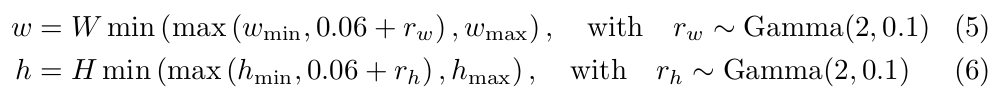

In [42]:
rh, rw = np.random.gamma(shape=GAMMA_PARAMS['shape'], scale=GAMMA_PARAMS['scale'], size=2)

h_perc = np.minimum(np.maximum(hmin, 0.06+rh), hmax)
w_perc = np.minimum(np.maximum(wmin, 0.06+rw), wmax)

h = (H*h_perc).round().astype(int)
w = (W*w_perc).round().astype(int)

print(f'Sampled values from Gamma distribution: rh={rh} and rw={rw}')
print(f'Sampled percentage sampled: h_perc={h_perc} x w_perc={w_perc}')
print(f'Sampled size for the patch that will be taken from the source image: h={h} x w={w}')

Sampled values from Gamma distribution: rh=0.196468643506098 and rw=0.07829979790296049
Sampled percentage sampled: h_perc=0.256468643506098 x w_perc=0.1382997979029605
Sampled size for the patch that will be taken from the source image: h=66 x w=35


Now, we need to extract this patch from the `src_image`. The problem is: not every location of the source image work for us.

That's why we need to create a mask. This will help us sampling patches that contains portions of the object - a constrain made on the paper. This way the mask is mandatory to use with images that require us to separate the `object` from its background. In case of `texture`, for example, a mask is not required, because the entire image contains information that is relevant to have in our patch.

For the images that contains an object and a plain background the masks are computed by threshold the pixel-wise difference to the background brightness, as showed in (8). Since the images are RGB images, we first reduce them to greyscale by averaging the colour channels. This way the threshold is straightforward.

For this part, we rely on *test-and-try* to define each the values for the equation, once each object has it's own value of `background_brightness` and `brightness_threshold`. These are them defined as hyper-parameters. 

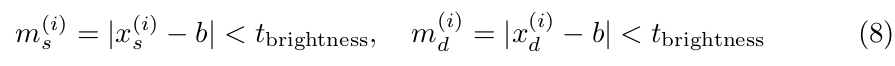

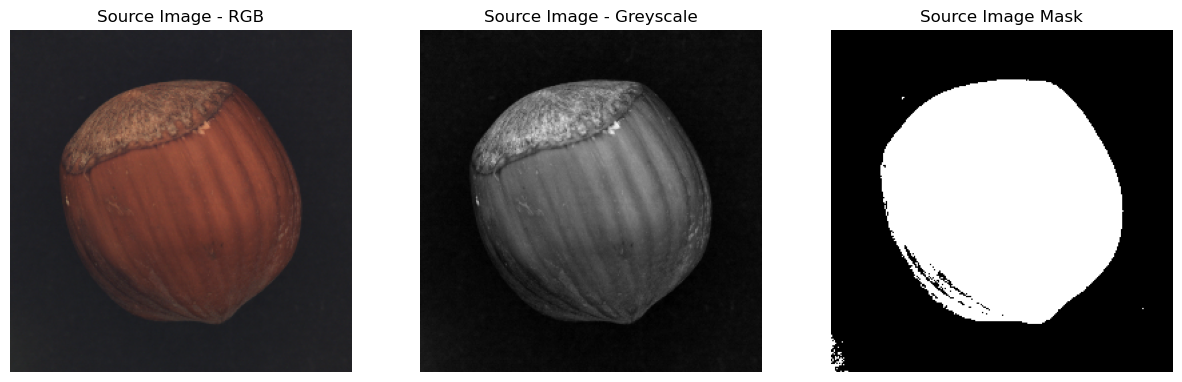

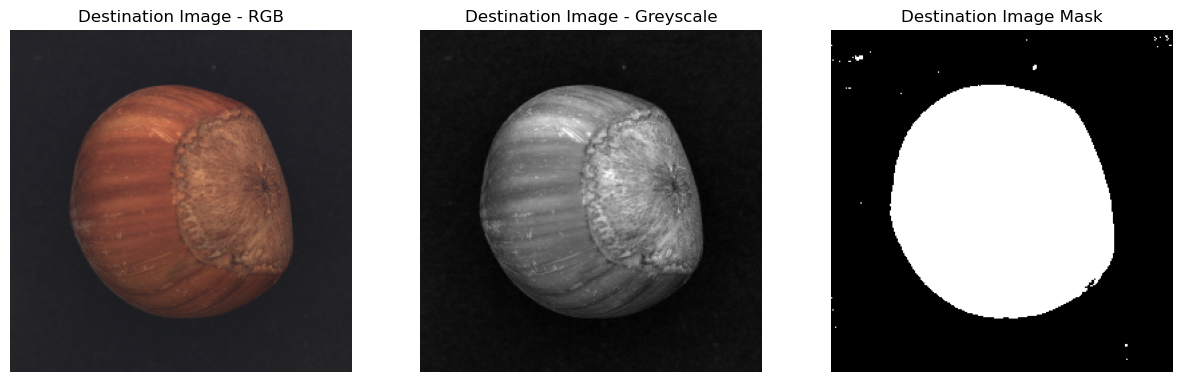

In [43]:
def get_mask(image, background_brightness, brightness_threshold, plain_background:bool=True):

    if plain_background:
        grey = image.mean(axis=2).astype(np.uint8)
        mask = (np.abs(grey - background_brightness) > brightness_threshold).astype(np.uint8) * 255
    else:
        pass
    return grey, mask

src_image_grey, src_mask = get_mask(image=src_image, background_brightness=MVTEC[CLASS]['background_brightness'], brightness_threshold=MVTEC[CLASS]['brightness_threshold'], plain_background=True)
display_images_side_by_side(images=[src_image, src_image_grey, src_mask], titles=['Source Image - RGB', 'Source Image - Greyscale', 'Source Image Mask'], config_cmap=[None, 'grey', 'grey'])

dest_image_grey, dest_mask = get_mask(image=dest_image, background_brightness=MVTEC[CLASS]['background_brightness'], brightness_threshold=MVTEC[CLASS]['brightness_threshold'], plain_background=True)
display_images_side_by_side(images=[dest_image, dest_image_grey, dest_mask], titles=['Destination Image - RGB', 'Destination Image - Greyscale', 'Destination Image Mask'], config_cmap=[None, 'grey', 'grey'])

By using the mask created we can them search for the localization of the patch by sampling the centres out of a **uniform distribution**, as showed in (7). 
 

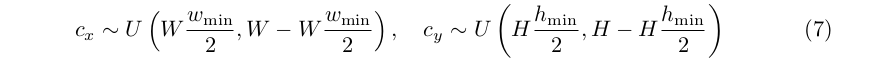

A constrain made by the paper within this search is that the patch should contain a portion of the object, a minimum quantity defined by `t_object`, as showed in the following:  

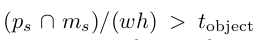

The idea is to iterate until find a patch that satisfies the above constrain.

Because the centre tuple should be kept as int, we sample by using the `randint()` method.

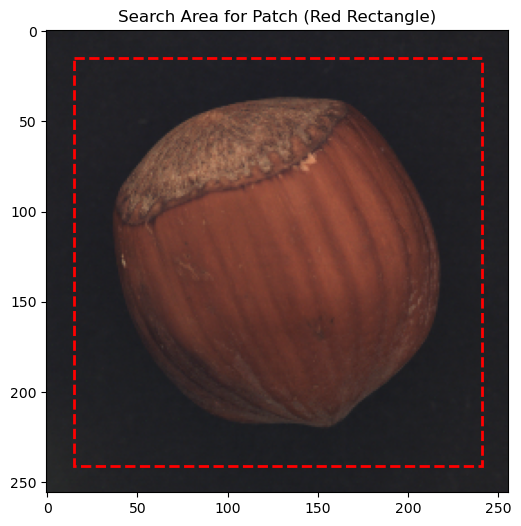

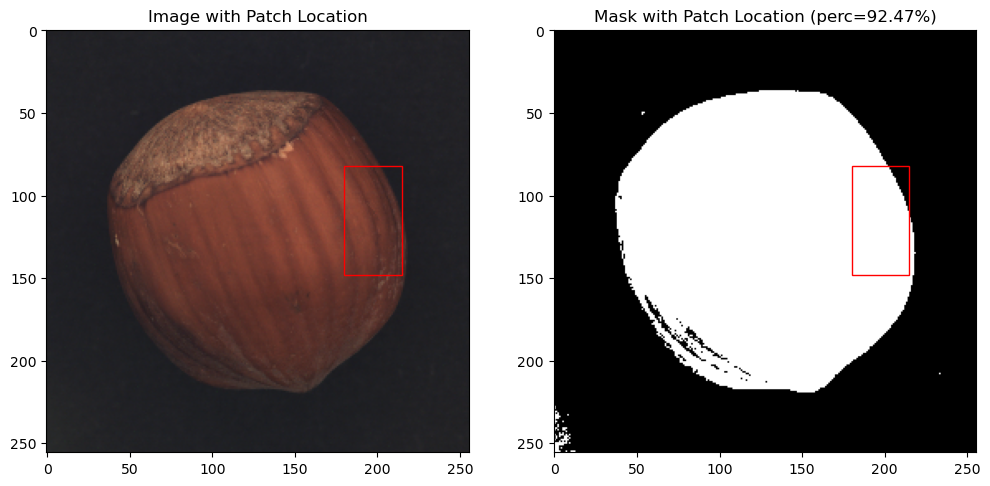

In [44]:
def check_contains_object(x, y, patch_size, min_object_ratio, mask):

    mask_patch = mask[y:y+patch_size[0], x:x+patch_size[1]]
    
    object_pixels = np.sum(mask_patch == 255)
    total_pixels = patch_size[0] * patch_size[1]
    object_ratio = object_pixels / total_pixels

    return bool(object_ratio >= min_object_ratio), object_ratio

def get_patch_centre(source_image, min_patch, mask, patch_size, agco_threshold=None, verbose:bool=False,
                     min_object_ratio=0.25, max_iterations=100):

    source_image_shape = source_image.shape

        # low and high limit of the Uniform distribution
    if agco_threshold is not None:
        y_range = min_patch[0], agco_threshold - min_patch[0]
        x_range = min_patch[1], source_image_shape[1] - min_patch[1]

    else:
        y_range = min_patch[0], (source_image_shape[0] - min_patch[0])
        x_range = min_patch[1], (source_image_shape[1] - min_patch[1])
    
    if verbose==1: plot_rectangule_img(rect_coods=(y_range,x_range), image=source_image)
    
    found_patch=False
    idx=0
    while (not found_patch) and (idx!=max_iterations):
     
        centre_y = random.randint(y_range[0], y_range[1]) # H
        centre_x = random.randint(x_range[0], x_range[1]) # W

        # find the region in the mask 
        y = centre_y - patch_size[0]//2
        x = centre_x - patch_size[1]//2

        # constrain
        found_patch, object_ratio = check_contains_object(x=x, y=y, patch_size=patch_size, min_object_ratio=min_object_ratio, mask=mask)
        
        if verbose==1: plot_patch_mask(x=x,y=y,patch_size1=patch_size, mask=mask, image=source_image, titles=["Image with Patch Location", f"Mask with Patch Location (perc={round(object_ratio*100, 2)}%)"])

        idx += 1
    return centre_y, centre_x

src_centre_y, src_centre_x = get_patch_centre(source_image=src_image, min_patch=min_patch_dim, mask=src_mask, patch_size=(h,w), agco_threshold=None, verbose=1)


Once a valid patch is found, it is resized by sampling a scalar factor from the a **normal distribution**, as show in (9). The paper also limits the factor depending if an `object` or a `texture`. 

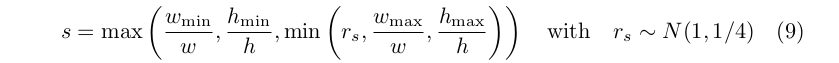


After scaling it, so computing the new dimension `h' = s*h` and `w' = s*w`, we also have to make sure, the new patch size doesn't falls out of the range of the computed maximum and minimum dimensions.

The new patch size after resizing is: 47 x 25, before was 66 x 35


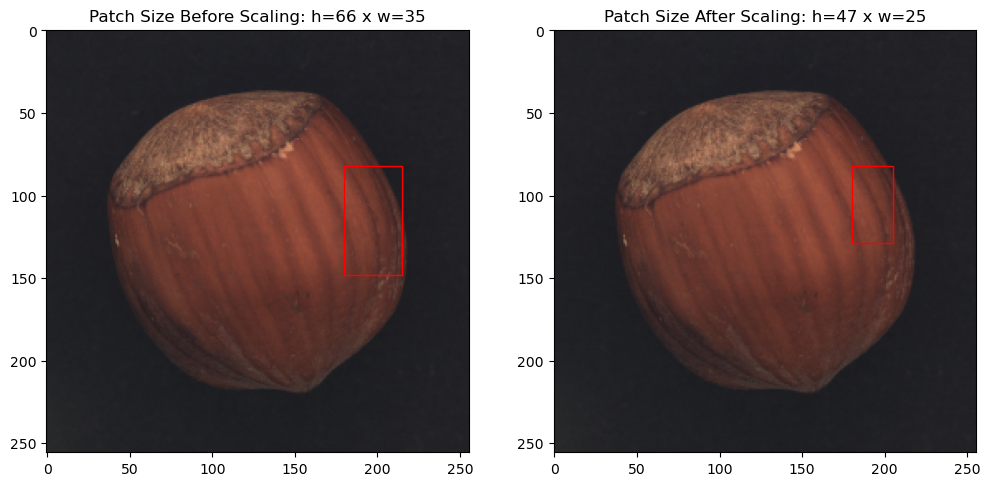

In [45]:
def get_scalar(min_patch_dim, max_patch_dim, resize_bounds):
    rs = np.clip(np.random.normal(loc=1, scale=0.25), resize_bounds[0], resize_bounds[1])
    min1 = np.minimum(max_patch_dim[1]/w, max_patch_dim[0]/h)
    min2 = np.minimum(rs, min1)
    max1 = np.maximum(min_patch_dim[1]/w, min_patch_dim[0]/h)

    return np.maximum(max1, min2)

def resize_patch(patch_size, resize_bounds, min_patch_dim, max_patch_dim):

    s = get_scalar(min_patch_dim=min_patch_dim, max_patch_dim=max_patch_dim, resize_bounds=resize_bounds)
    h = np.clip((s*patch_size[0]).astype(int), min_patch_dim[0], max_patch_dim[0])
    w = np.clip((s*patch_size[1]).astype(int), min_patch_dim[1], max_patch_dim[1])
    
    return h, w

h_prime, w_prime = resize_patch(patch_size=(h,w), resize_bounds=resize_bounds, min_patch_dim=min_patch_dim, max_patch_dim=max_patch_dim)

print(f'The new patch size after resizing is: {h_prime} x {w_prime}, before was {h} x {w}')

y = src_centre_y - h//2
x = src_centre_x - w//2

plot_patch_mask(x=x, y=y, patch_size1=(h,w), mask=src_image, patch_size2=(h_prime, w_prime), image=src_image, titles=[f"Patch Size Before Scaling: h={h} x w={w}", f"Patch Size After Scaling: h={h_prime} x w={w_prime}"])

After the resize of the patch is done, we need to find a location in the `dest_image`, where this patch can be blended into. The paper once more relies on a **uniform distribution** to sample the location of the centre where the image will be pasted on as stated in (10).

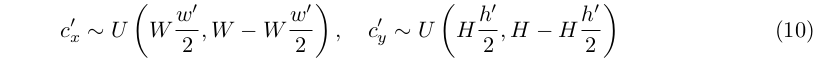

The centre should, however lead to a location that satisfies constrains (11) and (12).

In the first inequality we have that the location where the patch will be blended into should contain at least a certain part of the object, a threshold defined by `t_object`. 

In the second constrain it is required that a minimum of overlap happens between the objects within the `src_image` and the `dest_image`. `t_overlap` 

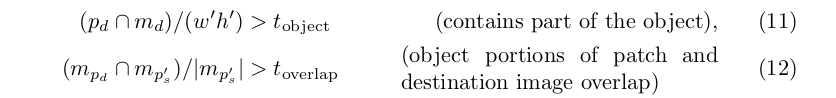

So we follow the same steps done for the `src_image`, we first found a mask for the `dest_image` and then use it to find a place to blend the patch, by applying the two above constrains.

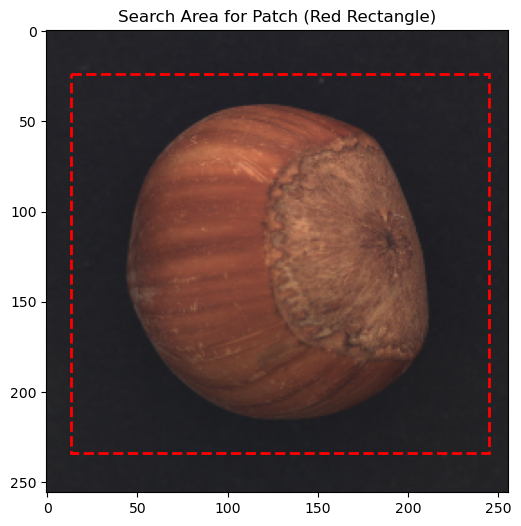

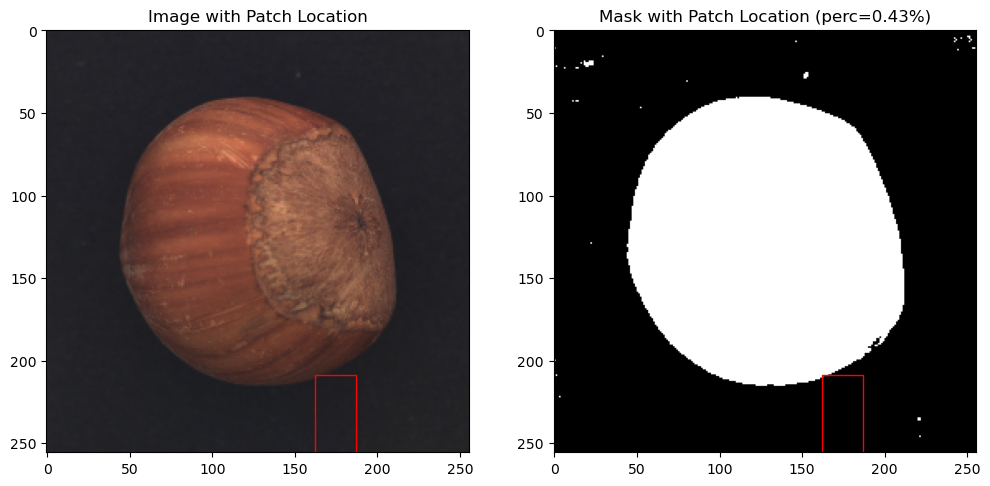

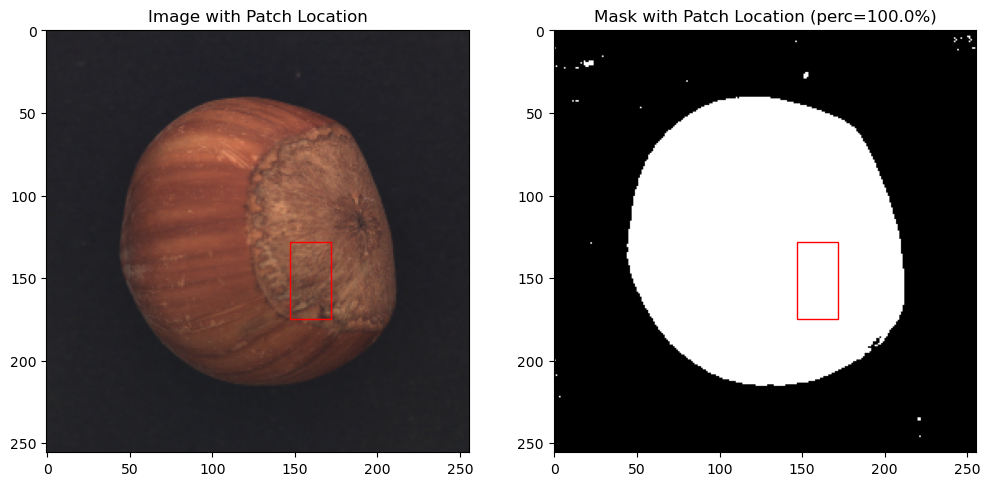

In [46]:
def check_overlap_objects(y, x, patch_size, dest_mask, src_mask, src_patch_centre, min_overlap=0.25):

    y_src = src_patch_centre[0] - patch_size[0]//2
    x_src = src_patch_centre[1] - patch_size[1]//2

    patch_mask = src_mask[y_src:y_src+patch_size[0], x_src:x_src+patch_size[1]]
    location_mask = dest_mask[y:y+patch_size[0], x:x+patch_size[1]]
    
    return np.logical_and(patch_mask, location_mask).sum() / np.sum(patch_mask/255) > min_overlap
    

def get_dest_centre(destination_image, src_mask, dest_mask, patch_size, src_patch_centre, agco_threshold=None, verbose:bool=False,
                     min_object_ratio=0.25, max_iterations=100):

    dest_image_shape = destination_image.shape

    if agco_threshold:
        y_range = dest_image_shape[0] - patch_size[0], agco_threshold
        x_range = patch_size[1]//2+1, dest_image_shape[1] - patch_size[1]//2+1

    else:
        y_range = patch_size[0]//2+1, dest_image_shape[0] - patch_size[0]//2+1
        x_range = patch_size[1]//2+1, dest_image_shape[1] - patch_size[1]//2+1
    
    if verbose==1: plot_rectangule_img(rect_coods=(y_range,x_range), image=destination_image)
    
    found_patch=False
    idx=0
    while (not found_patch) and (idx!=max_iterations):
     
        centre_y = random.randint(y_range[0], y_range[1]) # H
        centre_x = random.randint(x_range[0], x_range[1]) # W

        # find the region in the mask 
        y = centre_y - patch_size[0]//2
        x = centre_x - patch_size[1]//2

        # constrains
        found_patch, object_ratio = check_contains_object(x=x, y=y, patch_size=patch_size, min_object_ratio=min_object_ratio, mask=dest_mask)
        found_patch &= check_overlap_objects(y=y, x=x, patch_size=patch_size, src_patch_centre=src_patch_centre, dest_mask=dest_mask, src_mask=src_mask, min_overlap=0.25)

        if verbose==1: plot_patch_mask(x=x,y=y,patch_size1=patch_size, mask=dest_mask, image=destination_image, titles=["Image with Patch Location", f"Mask with Patch Location (perc={round(object_ratio*100, 2)}%)"])

        idx += 1

    return centre_y, centre_x

dest_centre_y, dest_centre_x = get_dest_centre(destination_image=dest_image, src_mask=src_mask, dest_mask=dest_mask, patch_size=(h_prime, w_prime), src_patch_centre=(src_centre_y, src_centre_x), agco_threshold=False, verbose=1, min_object_ratio=0.25, max_iterations=100)

A final part is to create the `patch_mask`, a mask that will help us extract the patch from the `src_image`. In the paper they also test by masking the patches with a union of 5 random ellipses to achieve less non-rectangular patch shapes.

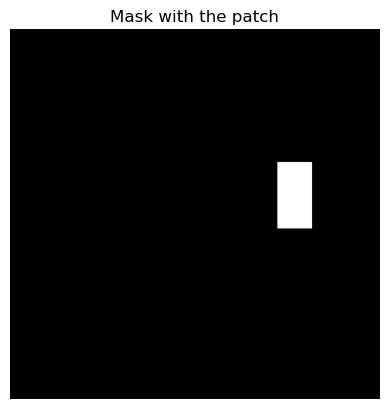

In [189]:
def add_blending_ellipses(mask, num_ellipses=5):

    min_dim=5
    max_dim=15
    overlap_ratio=0.5
    coords = np.argwhere(mask > 0)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    ellipse_mask = np.zeros_like(mask, dtype=np.uint8)

    # TODO: there are parts not being totally covered by the ellipse
    for _ in range(num_ellipses):

        side = np.random.choice(['top', 'bottom', 'left', 'right'])
        if side == 'top':
            y0 = np.random.randint(y_min - max_dim * (1 - overlap_ratio), y_min + max_dim * overlap_ratio)
            x0 = np.random.randint(x_min, x_max)
        elif side == 'bottom':
            y0 = np.random.randint(y_max - max_dim * overlap_ratio, y_max + max_dim * (1 - overlap_ratio))
            x0 = np.random.randint(x_min, x_max)
        elif side == 'left':
            x0 = np.random.randint(x_min - max_dim * (1 - overlap_ratio), x_min + max_dim * overlap_ratio)
            y0 = np.random.randint(y_min, y_max)
        elif side == 'right':
            x0 = np.random.randint(x_max - max_dim * overlap_ratio, x_max + max_dim * (1 - overlap_ratio))
            y0 = np.random.randint(y_min, y_max)

        a = np.random.randint(min_dim, max_dim)
        b = np.random.randint(min_dim, max_dim)
        theta = np.random.uniform(0, np.pi)

        y, x = np.ogrid[:mask.shape[0], :mask.shape[1]]
        ellipse = (((x - x0) * np.cos(theta) + (y - y0) * np.sin(theta)) / a) ** 2 + \
                  (((x - x0) * np.sin(theta) - (y - y0) * np.cos(theta)) / b) ** 2 <= 1

        ellipse_mask |= ellipse

    final_ellipse_mask = np.clip(mask + ellipse_mask, 0, 1)  
    
    return final_ellipse_mask

def create_patch_mask(center, size, mask_shape, num_ellipses=None):

    center_y, center_x = center
    patch_height, patch_width = size
    
    y_min = max(0, center_y - patch_height // 2)
    y_max = min(mask_shape[0], center_y + patch_height // 2)
    x_min = max(0, center_x - patch_width // 2)
    x_max = min(mask_shape[1], center_x + patch_width // 2)
    
    mask = np.zeros(mask_shape[:2], dtype=np.uint8)
    mask[y_min:y_max, x_min:x_max] = 255

    if num_ellipses:
        mask = add_blending_ellipses(mask=mask/255, num_ellipses=num_ellipses)
    
    return mask

mask = create_patch_mask(center=(src_centre_y, src_centre_x), size=(h_prime, w_prime), mask_shape=dest_image.shape, num_ellipses=None)

plt.imshow(mask, cmap='gray')
plt.title("Mask with the patch")
plt.axis('off')
plt.show()

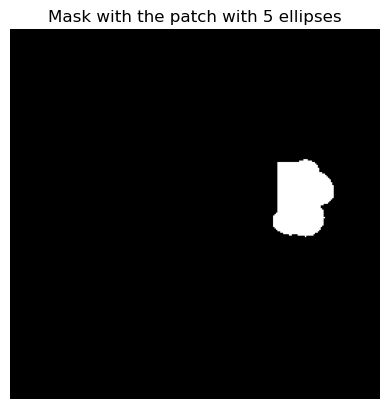

In [187]:

mask = create_patch_mask(center=(src_centre_y, src_centre_x), size=(h_prime, w_prime), mask_shape=dest_image.shape, num_ellipses=5)

plt.imshow(mask, cmap='gray')
plt.title("Mask with the patch with 5 ellipses")
plt.axis('off')
plt.show()

At the end of this first part of the data augmentation algorithm we have found from where we will take the patch in the `src_image` and where we will paste it in the `dest_image`. 

The `output` of this part that is relevante for the next part, the Poisson blending, are the `patch_mask`, so the mask with the information from where the patch will be taked from in the image, the `patch_size`, the size of this, and the `src_centre` and `dest_centre`.

In [190]:
print(f'The final patch size is: {h_prime} x {w_prime}')
print(f'The centre from where the patch will be taken from the src_image is: {src_centre_y} x {src_centre_x}')
print(f'The centre from where the patch will be taken from the src_image is: {dest_centre_y} x {dest_centre_x}')

The final patch size is: 47 x 25
The centre from where the patch will be taken from the src_image is: 115 x 197
The centre from where the patch will be taken from the src_image is: 151 x 159
